In [77]:
%reset

In [102]:
import warnings
from typing import Dict, List, Tuple, Union

import numpy as np
import pandas as pd
import scipy.linalg as slin
import scipy.optimize as sopt

from causalnex.structure import StructureModel
from causalnex.structure.transformers import DynamicDataTransformer
import argparse
import os
import sys
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import StochasticGhost
import Ghost

In [103]:
class Operations:


    def __init__(self, X, Xlags, lambda_w, lambda_a):

        # Create a list of linear layers based on layer_sizes
        self.X = X
        self.Xlags = Xlags
        self.lambda_w = lambda_w
        self.lambda_a = lambda_a



    
    def obj(self, initw, mbatch_size):
        """
        Objective function that the dynotears tries to minimise

        Args:
            wa_vec (np.ndarray): current adjacency vector with intra- and inter-slice weights

        Returns:
            float: objective
        """
        X = self.X
        Xlags = self.Xlags
        x_samples = np.random.choice(len(X), mbatch_size, replace=False)
        x = X[x_samples,:]
        xlags = Xlags[x_samples,:]
        n, d_vars = x.shape
        p_orders = xlags.shape[1] // d_vars

        _w_mat = initw[0]
        _a_mat = initw[1]
        _rho_w_mat = initw[2]
        _rho_a_mat = initw[3]
        loss = (
            0.5
            / n
            * np.square(
                np.linalg.norm(
                    x.dot(np.eye(d_vars, d_vars) - _w_mat) - xlags.dot(_a_mat), "fro"
                )
            )
        )
        """_h_value = _h(wa_vec)
        l1_penalty = lambda_w * (wa_vec[: 2 * d_vars**2].sum()) + lambda_a * (
            wa_vec[2 * d_vars**2 :].sum()
        ) 
        return loss + 0.5 * rho * _h_value * _h_value + alpha * _h_value + l1_penalty"""
        obj_loss = loss + self.lambda_w*np.sum(_rho_w_mat) + self.lambda_a*np.sum(_rho_a_mat)
        print(">>>> Obj loss: ", obj_loss)
        return obj_loss
    

    def obj_grad(self, initw, mbatch_size):
        """
        Gradient function used to compute next step in dynotears

        Args:
            wa_vec (np.ndarray): current adjacency vector with intra- and inter-slice weights

        Returns:
            gradient vector
        """
        X = self.X
        Xlags = self.Xlags
        x_samples = np.random.choice(len(X), mbatch_size, replace=False)
        x = X[x_samples,:]
        xlags = Xlags[x_samples,:]
        n, d_vars = x.shape
        p_orders = xlags.shape[1] // d_vars

        _w_mat = initw[0]
        _a_mat = initw[1]
        _rho_w_mat = initw[2]
        _rho_a_mat = initw[3]
        e_mat = slin.expm(_w_mat * _w_mat)
        
        E = x - x @ _w_mat - xlags @ _a_mat

        grad_w = - (1 / n) * x.T @ E 

        grad_a = - (1 / n) * xlags.T @ E

        grad_rho_w = self.lambda_w*np.sign(_rho_w_mat)

        grad_rho_a = self.lambda_a*np.sign(_rho_a_mat)

        #print("grad_rho_w shape: ", grad_rho_w.shape)
        #print("grad_rho_a shape: ", grad_rho_w.shape)
        #print("grad_w shape: ", grad_w.shape)
        #print("grad_a shape: ", grad_a.shape)


        obj_grad = np.concatenate([grad_w.flatten(), grad_a.flatten(), grad_rho_w.flatten(), grad_rho_a.flatten()], axis=0)

        # loss_grad_w = (
        #     -1.0
        #     / n
        #     * (x.T.dot(x.dot(np.eye(d_vars, d_vars) - _w_mat) - xlags.dot(_a_mat)))
        # )
        # obj_grad_w = (
        #     loss_grad_w
        # )
        # obj_grad_a = (
        #     -1.0
        #     / n
        #     * (xlags.T.dot(x.dot(np.eye(d_vars, d_vars) - _w_mat) - xlags.dot(_a_mat)))
        # )

        # grad_vec_w = np.append(
        #     obj_grad_w, -obj_grad_w, axis=0
        # ).flatten()
        # grad_vec_a = obj_grad_a.reshape(p_orders, d_vars**2)
        # grad_vec_a = np.hstack(
        #     (grad_vec_a, -grad_vec_a)
        # ).flatten()
        return obj_grad
    

    def conf_cycle(self, initw, mbatch_size, i):
        """
        Constraint function for detecting cycle

        Args:
            wa_vec (np.ndarray): current adjacency vector with intra- and inter-slice weights

        Returns:
            float: DAGness of the intra-slice adjacency matrix W (0 == DAG, >0 == cyclic)
        """
        #print("M batch size:", mbatch_size)
        X = self.X
        Xlags = self.Xlags
        x_samples = np.random.choice(len(X), mbatch_size, replace=False)
        x = X[x_samples,:]
        xlags = Xlags[x_samples,:]
        n, d_vars = x.shape
        #p_orders = xlags.shape[1] // d_vars
        #_w_mat, _a_mat = self._reshape_wa(wa_vec, d_vars, p_orders)
        _w_mat = initw[0]
        #print("wmat cons shape: ",_w_mat.shape)
        #_a_mat = wa_vec[1]#
        _hval = np.trace(slin.expm(_w_mat * _w_mat)) - d_vars
        print("Cycle constraint value:", _hval)
        return _hval
    
    def conf_grad_cycle(self, initw, mbatch_size, i):
        """
        gradient of constraint function for detecting cycle

        Args:
            initw (np.ndarray): current adjacency vector with intra- and inter-slice weights
            mbatch_size (int) : mini-batch size
            i : index of parameter (not used here but used to comply with the general function signature of constraint functionnnn)

        Returns:
            float: DAGness of the intra-slice adjacency matrix W (0 == DAG, >0 == cyclic)
        """
        #print("Inside conf grad cycle")
        X = self.X
        Xlags = self.Xlags
        x_samples = np.random.choice(len(X), mbatch_size, replace=False)
        x = X[x_samples,:]
        xlags = Xlags[x_samples,:]
        n, d_vars = x.shape
        p_orders = xlags.shape[1] // d_vars
        #_w_mat, _a_mat = self._reshape_wa(wa_vec, d_vars, p_orders)
        _w_mat = initw[0]
        _a_mat = initw[1]
        dj = np.eye(_w_mat.shape[0])
        dg = slin.expm(_w_mat * _w_mat)
        dh = (2 * _w_mat) 
        grad1 = np.matmul(dj, dg)
        gradf = np.matmul(grad1, dh)
        #print("shape cycle cons grad:", gradf.shape)
        # df = np.zeros((len(wa_vec), 1))
        # df[0][0] = 1
        # grad1 = np.matmul(dg, dj)
        # grad2 = np.matmul(dh, grad1)
        # print(grad2)
        # print(df)
        # grad3 = np.matmul(df, grad2)
        #print(gradf.flatten().shape)

        return np.concatenate([gradf.flatten(), np.zeros(2*len(initw[1].flatten()) + len(initw[0].flatten()))], axis=0)
    

    """
        confw_ub, confw_lb, confa_ub, confa_lb functions represent box constraints for inter-slice parameter values 
        derived from the L1-regularization of objective.
        -rho_i <= w_i <= rho_i
        -sigma_i <= a_i <= a_i

        Args:
            initw (np.ndarray): trainable params
            mbatch_size (int) : mini-batch size
            i : index of parameter

        Returns:
            float: the constraint function evaluation
        """

    def confw_ub(self, initw, mbatch_size, i):
        w = initw[0]
        rho_w = initw[2]
        if i >= (w.shape[0]*w.shape[1]):
            i = i - len(w.flatten())
        #print("w_", i, "<", self.bounds[i+1])
        w_i = w.flatten()[i] - rho_w.flatten()[i]
        return w_i

    def confw_lb(self, initw, mbatch_size, i):
        w = initw[0]
        rho_w = initw[2]
        if i >= (w.shape[0]*w.shape[1]):
            i = i - len(w.flatten())
        #print("w_", i, ">", -self.bounds[i+1])
        w_i = w.flatten()[i] + rho_w.flatten()[i]
        return -w_i
    
    def confa_ub(self, initw, mbatch_size, i):
        w = initw[0]
        a = initw[1]
        rho_a = initw[3]
        j = i - 2*len(w.flatten())
        if j >= a.shape[0]*a.shape[1]:
            j = j - len(a.flatten())
        #print("a_", j, "<", self.bounds[i+1])
        a_j = a.flatten()[j] - rho_a.flatten()[j]
        return a_j

    def confa_lb(self, initw, mbatch_size, i):
        w = initw[0]
        a = initw[1]
        rho_a = initw[3]
        j = i - 2*len(w.flatten())
        if j >= a.shape[0]*a.shape[1]:
            j = j - len(a.flatten())
        #print("a_", j, ">", -self.bounds[i+1])
        a_j = a.flatten()[j] + rho_a.flatten()[j]
        return -a_j
    

    """
        conf_grad_w_ub, conf_grad_w_lb, conf_grad_a_ub, conf_grad_a_lb functions represent gradients of box constraints for inter-slice parameter
        values derived from the L1-regularization of objective.
        -rho_i <= w_i <= rho_i
        -sigma_i <= a_i <= a_i

        Args:
            initw (np.ndarray): trainable params
            mbatch_size (int) : mini-batch size
            i : index of parameter

        Returns:
            float: the constraint function evaluation
        """
    
    def conf_grad_w_ub(self, initw, mbatch_size, i):
        
        w = initw[0]
        #rho_w = initw[2]
        #print("The initw:",initw)
        w_grad = np.zeros(w.shape[0]*w.shape[1])
        rho_w_grad = np.zeros(w.shape[0]*w.shape[1])
        if i >= len(w_grad):
            i = i-len(w_grad)
        w_grad[i] = 1
        rho_w_grad[i] = -1
        w_ub_grad =  np.concatenate([w_grad, np.zeros(len(initw[1].flatten())), rho_w_grad, np.zeros(len(initw[3].flatten()))], axis=0)
        #print("w_", i, " grad", w_ub_grad)
        #print("w_ub_grad shape:",w_ub_grad.shape)
        return w_ub_grad
    

    def conf_grad_w_lb(self, initw, mbatch_size, i):
        
        #print("inside grad_cal w_lb")
        w = initw[0]
        w_grad = np.zeros(w.shape[0]*w.shape[1])
        rho_w_grad = np.zeros(w.shape[0]*w.shape[1])
        if i >= len(w_grad):
            i = i-len(w_grad)
        w_grad[i] = -1
        rho_w_grad[i] = -1
        w_lb_grad =  np.concatenate([w_grad, np.zeros(len(initw[1].flatten())), rho_w_grad, np.zeros(len(initw[3].flatten()))], axis=0)
        
        #print("w_lb_grad shape:",w_lb_grad.shape)
        return w_lb_grad
    
    def conf_grad_a_ub(self, initw, mbatch_size, i):
        
        w = initw[0]
        a = initw[1]
        j = i - 2*len(w.flatten())
        a_grad = np.zeros(a.shape[0]*a.shape[1])
        rho_a_grad = np.zeros(a.shape[0]*a.shape[1])
        if j >= len(a_grad):
            j = j-len(a_grad)
        a_grad[j] = 1
        rho_a_grad[j] = -1
        #print([np.zeros(len(initw[0].flatten())), a_grad, np.zeros(len(initw[2].flatten())), rho_a_grad])
        a_ub_grad = np.concatenate([np.zeros(len(initw[0].flatten())), a_grad, np.zeros(len(initw[2].flatten())), rho_a_grad], axis=0)
        
        #print("a_ub_grad shape:",a_ub_grad.shape)
        return a_ub_grad
    
    def conf_grad_a_lb(self, initw, mbatch_size, i):
        
        w = initw[0]
        a = initw[1]
        j = i - 2*len(w.flatten())
        a_grad = np.zeros(a.shape[0]*a.shape[1])
        rho_a_grad = np.zeros(a.shape[0]*a.shape[1])
        if j >= len(a_grad):
            j = j-len(a_grad)
        a_grad[j] = -1
        rho_a_grad[j] = -1
        a_lb_grad = np.concatenate([np.zeros(len(initw[0].flatten())), a_grad, np.zeros(len(initw[2].flatten())), rho_a_grad], axis=0)
        
        #print("a_lb_grad shape:",a_lb_grad.shape)
        return a_lb_grad
    
    def conf_rho_w(self, initw, mbatch_size, i):

        rho_w = initw[2]
        i = i - 2*(len(initw[0].flatten()) + len(initw[1].flatten()))
        rho_w_i = rho_w.flatten()[i]
        return -rho_w_i
    
    def conf_rho_a(self, initw, mbatch_size, i):

        rho_a = initw[3]
        i = i - 2*(len(initw[0].flatten()) + len(initw[1].flatten())) - len(initw[2].flatten())
        rho_a_i = rho_a.flatten()[i]
        return -rho_a_i

    def conf_grad_rho_w(self, initw, mbatch_size, i):
        
        rho_w_grad = np.zeros(len(initw[2].flatten()))
        i = i - 2*(len(initw[0].flatten()) + len(initw[1].flatten()))
        rho_w_grad[i] = -1
        rho_w_bd_grad = np.concatenate([np.zeros(len(initw[0].flatten())), np.zeros(len(initw[1].flatten()))
                                  , rho_w_grad, np.zeros(len(initw[3].flatten()))], axis=0)
        
        #print("rho_w_bd_grad shape", rho_w_bd_grad.shape)
        return rho_w_bd_grad
    
    def conf_grad_rho_a(self, initw, mbatch_size, i):
        
        rho_a_grad = np.zeros(len(initw[3].flatten()))
        i = i - 2*(len(initw[0].flatten()) + len(initw[1].flatten())) - len(initw[2].flatten())
        rho_a_grad[i] = -1
        rho_a_bd_grad = np.concatenate([np.zeros(len(initw[0].flatten())), np.zeros(len(initw[1].flatten()))
                                  , np.zeros(len(initw[2].flatten())), rho_a_grad], axis=0)
        
        #print("rho_a_bd_grad shape", rho_a_bd_grad.shape)
        return rho_a_bd_grad
    
    def get_box_cons(self, initw, cons):

        _w_mat = initw[0]
        _a_mat = initw[1]
        _rho_w_mat = initw[2]
        _rho_a_mat = initw[3]
        
        #_w_mat, _a_mat = self._reshape_wa(wa_vec, d_vars, p_orders)
    
        for i in range(len(_w_mat.reshape(-1))):
            cons.append(self.confw_ub)
        for i in range(len(_w_mat.reshape(-1))):
            cons.append(self.confw_lb)

        for i in range(len(_a_mat.reshape(-1))):
            cons.append(self.confa_ub)
        for i in range(len(_a_mat.reshape(-1))):
            cons.append(self.confa_lb)

        for i in range(len(_rho_w_mat.reshape(-1))):
            cons.append(self.conf_rho_w)
        for i in range(len(_rho_a_mat.reshape(-1))):
            cons.append(self.conf_rho_a)    

        return cons

    def get_box_cons_grads(self, initw, cons_grads):
        
        _w_mat = initw[0]
        _a_mat = initw[1]
        _rho_w_mat = initw[2]
        _rho_a_mat = initw[3]

        for i in range(len(_w_mat.reshape(-1))):
            cons_grads.append(self.conf_grad_w_ub)
        for i in range(len(_w_mat.reshape(-1))):
            cons_grads.append(self.conf_grad_w_lb)
        
        for i in range(len(_a_mat.reshape(-1))):
            cons_grads.append(self.conf_grad_a_ub)
        for i in range(len(_a_mat.reshape(-1))):
            cons_grads.append(self.conf_grad_a_lb)
        
        for i in range(len(_rho_w_mat.reshape(-1))):
            cons_grads.append(self.conf_grad_rho_w)
        for i in range(len(_rho_a_mat.reshape(-1))):
            cons_grads.append(self.conf_grad_rho_a)

        return cons_grads
    


def get_vars(time_series, p, tabu_edges, tabu_parent_nodes, tabu_child_nodes):

    time_series = [time_series] if not isinstance(time_series, list) else time_series

    X, Xlags = DynamicDataTransformer(p=p).fit_transform(time_series, return_df=False)

    col_idx = {c: i for i, c in enumerate(time_series[0].columns)}
    idx_col = {i: c for c, i in col_idx.items()}

    if tabu_edges:
        tabu_edges = [(lag, col_idx[u], col_idx[v]) for lag, u, v in tabu_edges]
    if tabu_parent_nodes:
        tabu_parent_nodes = [col_idx[n] for n in tabu_parent_nodes]
    if tabu_child_nodes:
        tabu_child_nodes = [col_idx[n] for n in tabu_child_nodes]

    return X, Xlags, tabu_edges, tabu_parent_nodes, tabu_child_nodes, col_idx, idx_col


def get_cons_bounds(X, Xlags, tabu_edges, tabu_parent_nodes, tabu_child_nodes):
    _, d_vars = X.shape
    p_orders = Xlags.shape[1] // d_vars
    
    bnds_w = 2 * [
        (0, 0)
        if i == j
        else (0, 0)
        if tabu_edges is not None and (0, i, j) in tabu_edges
        else (0, 0)
        if tabu_parent_nodes is not None and i in tabu_parent_nodes
        else (0, 0)
        if tabu_child_nodes is not None and j in tabu_child_nodes
        else (0, None)
        for i in range(d_vars)
        for j in range(d_vars)
    ]

    bnds_a = []
    for k in range(1, p_orders + 1):
        bnds_a.extend(
            2
            * [
                (0, 0)
                if tabu_edges is not None and (k, i, j) in tabu_edges
                else (0, 0)
                if tabu_parent_nodes is not None and i in tabu_parent_nodes
                else (0, 0)
                if tabu_child_nodes is not None and j in tabu_child_nodes
                else (0, None)
                for i in range(d_vars)
                for j in range(d_vars)
            ]
        )


    bnds = bnds_w + bnds_a
    return bnds


def _reshape_wa( wa_vec, d_vars, p_orders):

        w_tilde = wa_vec.reshape([2 * (p_orders + 1) * d_vars, d_vars])
        w_plus = w_tilde[:d_vars, :]
        w_minus = w_tilde[d_vars : 2 * d_vars, :]
        w_mat = w_plus - w_minus
        a_plus = (
            w_tilde[2 * d_vars :]
            .reshape(2 * p_orders, d_vars**2)[::2]
            .reshape(d_vars * p_orders, d_vars)
        )
        a_minus = (
            w_tilde[2 * d_vars :]
            .reshape(2 * p_orders, d_vars**2)[1::2]
            .reshape(d_vars * p_orders, d_vars)
        )
        a_mat = a_plus - a_minus
        #print("a shape: ",a_mat.shape, "w shape: ",w_mat.shape)
        return w_mat, a_mat


In [104]:
def paramvals(maxiter, beta, rho, lamb, hess, tau, mbsz, numcon, geomp, stepdecay, gammazero, zeta, N, n, lossbound, scalef):
    params = {
        'maxiter': maxiter,  # number of iterations performed
        'beta': beta,  # trust region size
        'rho': rho,  # trust region for feasibility subproblem
        'lamb': lamb,  # weight on the subfeasibility relaxation
        'hess': hess,  # method of computing the Hessian of the QP, options include 'diag' 'lbfgs' 'fisher' 'adamdiag' 'adagraddiag'
        'tau': tau,  # parameter for the hessian
        'mbsz': mbsz,  # the standard minibatch size, used for evaluating the progress of the objective and constraint
        'numcon': numcon,  # number of constraint functions
        'geomp': geomp,  # parameter for the geometric random variable defining the number of subproblem samples
        'stepdecay': stepdecay, # strategy for step decrease, options include 'dimin' 'stepwise' 'slowdimin' 'constant'
        'gammazero': gammazero,  # initial stepsize
        'zeta': zeta,  # parameter associated with the stepsize iteration
        'N': N,  # Train/val sample size
        'n': n,  # Total number of parameters
        'lossbound': lossbound, #Bound on constraint loss
        'scalef': scalef #Scaling factor for constraints
    }
    return params

In [105]:
import sys
import types

def reload_package(root_module):
    package_name = root_module.__name__

    # get a reference to each loaded module
    loaded_package_modules = dict([
        (key, value) for key, value in sys.modules.items()
        if key.startswith(package_name) and isinstance(value, types.ModuleType)])

    # delete references to these loaded modules from sys.modules
    for key in loaded_package_modules:
        del sys.modules[key]

    # load each of the modules again;
    # make old modules share state with new modules
    for key in loaded_package_modules:
        print("Loading ", key)
        newmodule = __import__(key)
        oldmodule = loaded_package_modules[key]
        oldmodule.__dict__.clear()
        oldmodule.__dict__.update(newmodule.__dict__)

def _matrices_to_structure_model(w_est, a_est):
    sm = StructureModel()
    lag_cols = [
        f"{var}_lag{l_val}"
        for l_val in range(1 + (a_est.shape[0] // a_est.shape[1]))
        for var in range(a_est.shape[1])
    ]
    sm.add_nodes_from(lag_cols)
    sm.add_edges_from(
        [
            (lag_cols[i], lag_cols[j], {"weight": w_est[i, j]})
            for i in range(w_est.shape[0])
            for j in range(w_est.shape[1])
            if w_est[i, j] != 0
        ]
    )
    sm.add_edges_from(
        [
            (lag_cols[i + w_est.shape[0]], lag_cols[j], {"weight": a_est[i, j]})
            for i in range(a_est.shape[0])
            for j in range(a_est.shape[1])
            if a_est[i, j] != 0
        ]
    )
    return sm


def _format_name_from_pandas(idx_col, from_numpy_node):
    idx, lag_val = from_numpy_node.split("_lag")
    return f"{idx_col[int(idx)]}_lag{lag_val}"

In [148]:
import StochasticGhost
reload_package(StochasticGhost)

Loading  StochasticGhost


In [107]:
import Ghost
reload_package(Ghost)

Loading  Ghost
Loading  Ghost2


In [108]:
import Ghost2
reload_package(Ghost2)

Loading  Ghost2


In [149]:

time_series_path = "../data/data_8n_100ts_30N.csv"
data = pd.read_csv(time_series_path)
T = 10
d = 8
M = len(data)-2
p = 1
#T = 2
#d = 3
h_bound = 1e-5
trials = 1
#lambda_a = np.random.normal(size=[M*(T+1-p), 3])
#lambda_a = np.triu(lambda_a, k=1)
#lambda_w = np.random.normal(size=[3, 3])
# lambda_w = 0.6
# lambda_a = 0.6
w_threshold = 0
a_threshold = 0
max_iter = 200
num_segments = len(data) // (p+1)
split_data = np.array_split(data, num_segments)
w_bound = 0.05
a_bound = 0.05
ftrial = []
ctrial = []
weights = []
min_weights = []
dataframes = []
#dfs = np.zeros((len(data), T, d))
for i in range(len(data)):
    ret = np.array([data.iloc[i][j::d] for j in range(d)]).T
    col_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
    # Create DataFrame
    df = pd.DataFrame(ret, columns=col_names)
    dataframes.append(df)

for trial in range(trials):
    
    cons = []
    cons_grads = []

    X, Xlags, tabu_edges, tabu_parent_nodes, tabu_child_nodes, col_idx, idx_col = get_vars(dataframes, p, None, None, None) 

    n, d_vars = X.shape
    p_orders = Xlags.shape[1] // d_vars

    num_trials = len(dataframes)


    # initialise matrix, weights and constraints
    wa_vec = np.random.rand(2 * (p_orders + 1) * d_vars**2) - 1


    #wa_vec = np.zeros(2 * (p_orders + 1) * d_vars**2)

    print(p_orders, d_vars)

    _w_mat, _a_mat = _reshape_wa(wa_vec, d_vars, p_orders)

    #_rho_w_mat = np.zeros(_w_mat.shape)
    #_rho_a_mat = np.zeros(_a_mat.shape)

    _rho_w_mat = np.random.rand(*_w_mat.shape)
    _rho_a_mat = np.random.rand(*_a_mat.shape)

    initw = [_w_mat, _a_mat, _rho_w_mat, _rho_a_mat]

    num_param = 2*_w_mat.shape[0]*_w_mat.shape[1] + 2*_a_mat.shape[0]*_a_mat.shape[1]


    ## Bounds for the parameters ##
    rho_list = np.zeros(3*initw[0].shape[0]*initw[0].shape[1] + 3*initw[1].shape[0]*initw[1].shape[1])

    cons_bounds = np.append(np.array([h_bound]), rho_list)
    print(cons_bounds)
    print("Total number of constraints: ",len(cons_bounds))
    #print("box constraints: ",len(cons_bounds))
    cons_bounds = cons_bounds.tolist()


    operations = Operations(X, Xlags, lambda_w=0.1, lambda_a=0.1)

    

    print("w shape: ", _w_mat.shape)
    print("a shape: ", _a_mat.shape)

    ## Graph cycle constraint ##
    cons.append(operations.conf_cycle)

    ## constraints on weight components ##
    cons = operations.get_box_cons(initw, cons)

    ## Graph cycle constraint grad ##
    cons_grads.append(operations.conf_grad_cycle)

    ## constraints grad of weight components ##
    cons_grads = operations.get_box_cons_grads(initw, cons_grads)

    



    # set the scaling factor of each constraint
    scalefs = np.ones(len(cons)).tolist()


    #print(len(scalefs))

    params = paramvals(maxiter=max_iter, beta=1, rho=0.5, lamb=0.5, hess='diag', tau=64, mbsz=10,
                            numcon=len(cons), geomp=0.2, stepdecay='dimin', gammazero=0.5, zeta=0.2, N=num_trials, n=num_param, 
                            lossbound=cons_bounds, scalef=scalefs)


    # Best params for SGhost : large tau gives a better convergence in terms of diminishing norm of step
    # Ghost with no subsampling gives better convergence                        


    w, iterfs, itercs, min_w, steps = StochasticGhost.StochasticGhost(operations.obj, operations.obj_grad, cons, cons_grads, initw, params)

    if np.isnan(w[0]).any():
            print("reached infeasibility not saving the model")
    else:
        ftrial.append(iterfs)
        ctrial.append(itercs)
        weights.append(w)
        min_weights.append(min_w)

1 8
[1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0

/home/choudhar/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/choudhar/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/choudhar/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


>>>> Obj loss:  9.953030618565853
Cycle constraint value: 2.588547473680565
>>>> Obj loss:  10.637868550067171
Cycle constraint value: 2.588547473680565
>>>> Obj loss:  9.133973739451472
Cycle constraint value: 2.588547473680565
Inf norm of step-size:  0.14113980495131323
>>>> Obj loss:  8.549611317563913
Cycle constraint value: 2.263249936335402
Iteration:  4
>>>> Obj loss:  10.004854004529857
Cycle constraint value: 2.263249936335402
>>>> Obj loss:  8.682766523522734
Cycle constraint value: 2.263249936335402
>>>> Obj loss:  8.339376776765224
Cycle constraint value: 2.263249936335402
>>>> Obj loss:  9.12866214478017
Cycle constraint value: 2.263249936335402
Inf norm of step-size:  0.10821539099723482
>>>> Obj loss:  8.693532233128863
Cycle constraint value: 1.9918544675040817
Iteration:  5
>>>> Obj loss:  8.598744120752658
Cycle constraint value: 1.9918544675040817
>>>> Obj loss:  8.52916924780897
Cycle constraint value: 1.9918544675040817
>>>> Obj loss:  8.491166403690972
Cycle const

In [140]:
#parser = argparse.ArgumentParser(description="Dynamically import the model class")
#parser.add_argument("--time_series", type=str, help="The time series data in form of csv")
#args = parser.parse_args()
#time_series = args.time_series
#parent_dir = os.path.dirname(os.path.abspath(__file__))
#data_dir = os.path.abspath(os.path.join(parent_dir, "../data/"))
# Construct the absolute path to the CSV file
time_series_path = "../data/time_series.csv"
data = pd.read_csv(time_series_path)
data = data[['X', 'Y', 'Z']]
M = len(data)-2
p = 2
#T = 2
d = 3
h_bound = 1e-5
trials = 30
#lambda_a = np.random.normal(size=[M*(T+1-p), 3])
#lambda_a = np.triu(lambda_a, k=1)
#lambda_w = np.random.normal(size=[3, 3])
# lambda_w = 0.6
# lambda_a = 0.6
w_threshold = 0
a_threshold = 0
max_iter = 200
num_segments = len(data) // (p+1)
split_data = np.array_split(data, num_segments)
w_bound = 0.05
a_bound = 0.05
ftrial = []
ctrial = []
weights = []
min_weights = []
## The dimensions of X will be : M(T-p+1)
## Here p -> the time lag max i.e. X_t = f(X_t-1, ....X_t-p)

# Convert each numpy array back into a DataFrame
dataframes = [segment.reset_index(drop=True) for segment in split_data]

print((dataframes[0]))

#max_iter = len(dataframes)
#num_param = (p*d)*d  +   d*d

#print(len(dataframes))

for trial in range(trials):
    
    cons = []
    cons_grads = []

    X, Xlags, tabu_edges, tabu_parent_nodes, tabu_child_nodes, col_idx, idx_col = get_vars(data, p, None, None, None) 

    n, d_vars = X.shape
    p_orders = Xlags.shape[1] // d_vars

    num_trials = len(dataframes)


    # initialise matrix, weights and constraints
    wa_vec = np.random.rand(2 * (p_orders + 1) * d_vars**2) - 1


    #wa_vec = np.zeros(2 * (p_orders + 1) * d_vars**2)

    print(p_orders, d_vars)

    _w_mat, _a_mat = _reshape_wa(wa_vec, d_vars, p_orders)

    #_rho_w_mat = np.zeros(_w_mat.shape)
    #_rho_a_mat = np.zeros(_a_mat.shape)

    _rho_w_mat = np.random.rand(*_w_mat.shape)
    _rho_a_mat = np.random.rand(*_a_mat.shape)

    initw = [_w_mat, _a_mat, _rho_w_mat, _rho_a_mat]

    num_param = 2*_w_mat.shape[0]*_w_mat.shape[1] + 2*_a_mat.shape[0]*_a_mat.shape[1]


    ## Bounds for the parameters ##
    rho_list = np.zeros(3*initw[0].shape[0]*initw[0].shape[1] + 3*initw[1].shape[0]*initw[1].shape[1])

    cons_bounds = np.append(np.array([h_bound]), rho_list)
    print(cons_bounds)
    print("Total number of constraints: ",len(cons_bounds))
    #print("box constraints: ",len(cons_bounds))
    cons_bounds = cons_bounds.tolist()


    operations = Operations(X, Xlags, lambda_w=0.1, lambda_a=0.5)

    

    print("w shape: ", _w_mat.shape)
    print("a shape: ", _a_mat.shape)

    ## Graph cycle constraint ##
    cons.append(operations.conf_cycle)

    ## constraints on weight components ##
    cons = operations.get_box_cons(initw, cons)

    ## Graph cycle constraint grad ##
    cons_grads.append(operations.conf_grad_cycle)

    ## constraints grad of weight components ##
    cons_grads = operations.get_box_cons_grads(initw, cons_grads)

    



    # set the scaling factor of each constraint
    scalefs = np.ones(len(cons)).tolist()


    #print(len(scalefs))

    params = paramvals(maxiter=max_iter, beta=1e7, rho=1e5, lamb=0.5, hess='diag', tau=128, mbsz=10,
                            numcon=len(cons), geomp=0.05, stepdecay='dimin', gammazero=0.5, zeta=0.2, N=num_trials, n=num_param, 
                            lossbound=cons_bounds, scalef=scalefs)


    # Best params for SGhost : large tau gives a better convergence in terms of diminishing norm of step
    # Ghost with no subsampling gives better convergence                        


    w, iterfs, itercs, min_w = Ghost2.StochasticGhost(operations.obj, operations.obj_grad, cons, cons_grads, initw, params)

    if np.isnan(w[0]).any():
            print("reached infeasibility not saving the model")
    else:
        ftrial.append(iterfs)
        ctrial.append(itercs)
        weights.append(w)
        min_weights.append(min_w)



    

#     if np.isnan(w[0]).any():
#             print("reached infeasibility not saving the model")
#     else:
#         ftrial.append(iterfs)
#         ctrial.append(itercs)

#         w_mat = w[0]
#         a_mat = w[1]
#         w_mat[(w_mat) < w_threshold] = 0
#         a_mat[(a_mat) < a_threshold] = 0
#         g = _matrices_to_structure_model(w_mat, a_mat)

#         sm = StructureModel()

#         sm.add_nodes_from(
#         [f"{var}_lag{l_val}" for var in col_idx.keys() for l_val in range(p + 1)]
#         )
#         sm.add_weighted_edges_from(
#                 [
#                 (
#                         _format_name_from_pandas(idx_col, u),
#                         _format_name_from_pandas(idx_col, v),
#                         w,
#                 )
#                 for u, v, w in g.edges.data("weight")
#                 ],
#                 origin="learned",
#         )

#         viz = plot_structure(
#         sm,
#         all_node_attributes=NODE_STYLE.WEAK,
#         all_edge_attributes=EDGE_STYLE.WEAK,
#         )

#         viz.save_graph('causal_graphs/causal_graph'+str(trial)+'.html')

          X         Y         Z
0  0.496714  0.647689 -0.234153
1 -0.138264  1.523030  0.000000
2  0.070530  1.049509  0.704448
2 3
[1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00
 0.e+00 0.e+00]
Total number of constraints:  82
w shape:  (3, 3)
a shape:  (6, 3)
>>>> Obj loss:  6.988531296691156
Cycle constraint value: 1.0329556617896527
Iteration :  1
>>>> Obj loss:  6.83651125670877
Cycle constraint value: 1.0329556617896527
Inf norm of step-size:  0.3654877139988017
>>>> O

/home/choudhar/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/choudhar/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/choudhar/anaconda3/envs/ghost/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


Cycle constraint value: 0.039345539642604344
Inf norm of step-size:  0.033625123272582304
>>>> Obj loss:  5.849512178401534
Cycle constraint value: 0.03541772149627764
Iteration :  25
>>>> Obj loss:  5.971146740013083
Cycle constraint value: 0.03541772149627764
Inf norm of step-size:  0.03223640801950471
>>>> Obj loss:  6.170565373745153
Cycle constraint value: 0.03187132411928095
Iteration :  26
>>>> Obj loss:  5.952151714733233
Cycle constraint value: 0.03187132411928095
Inf norm of step-size:  0.030714086271911335
>>>> Obj loss:  5.634786730457034
Cycle constraint value: 0.02882209301516081
Iteration :  27
>>>> Obj loss:  5.991981189188561
Cycle constraint value: 0.02882209301516081
Inf norm of step-size:  0.02945365852800982
>>>> Obj loss:  6.372527510827583
Cycle constraint value: 0.02611210673926534
Iteration :  28
>>>> Obj loss:  5.941558045794128
Cycle constraint value: 0.02611210673926534
Inf norm of step-size:  0.027605044271418445
>>>> Obj loss:  6.376353568837745
Cycle cons

KeyboardInterrupt: 

In [157]:
iterfs

6000

In [172]:
cons1 = itercs[:,0]    

Text(0, 0.5, 'value')

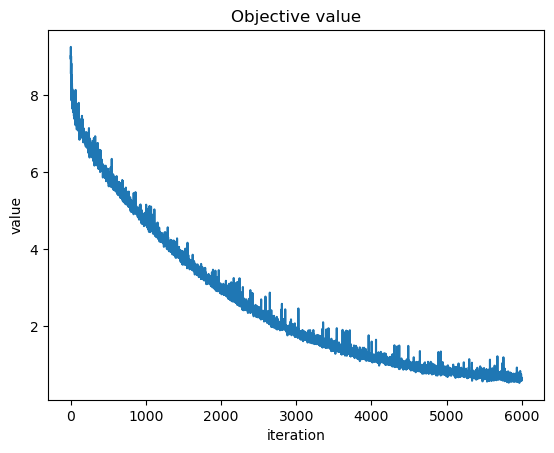

In [176]:
import matplotlib.pyplot as plt
plt.plot(iterfs)
plt.title("Objective value")
plt.xlabel("iteration")
plt.ylabel("value")

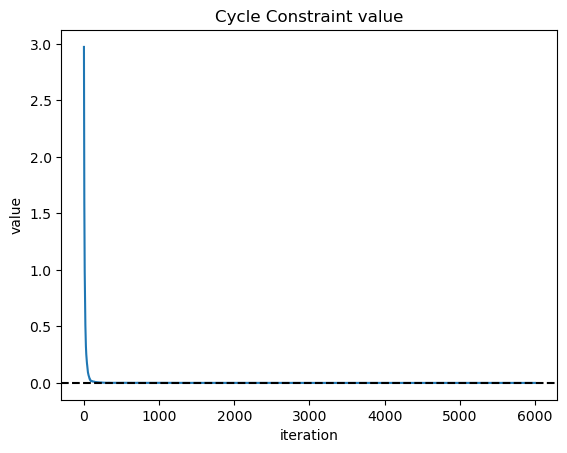

In [175]:
plt.plot(cons1)
plt.title("Cycle Constraint value")
plt.xlabel("iteration")
plt.ylabel("value")
plt.axhline(y=0, color='black', linestyle='--')

In [97]:
ftrial = np.array(ftrial).T
ctrial = np.array(ctrial).T

In [98]:
print(ftrial.shape)
print(ctrial.shape)
#print((type(ftrial[0])))

(1, 21)
(21,)


In [100]:
df_ftrial = pd.DataFrame(ftrial, columns=range(1, ftrial.shape[1]+1), index=range(1, ftrial.shape[0]+1))
#df_ctrial1 = pd.DataFrame(ctrial[0], columns=range(1, ctrial.shape[2]+1), index=range(1, ctrial.shape[1]+1))
#df_ctrial2 = pd.DataFrame(ctrial[1], columns=range(1, ctrial.shape[2]+1), index=range(1, ctrial.shape[1]+1))
#df_ctrial3 = pd.DataFrame(ctrial[2], columns=range(1, ctrial.shape[2]+1), index=range(1, ctrial.shape[1]+1))

In [93]:
df_ftrial.to_csv('../utils/dyno_ftrialx.csv')
#df_ctrial1.to_csv('../utils/dyno_ctrialx1.csv')
#df_ctrial2.to_csv('../utils/dyno_ctrialx2.csv')
#df_ctrial3.to_csv('../utils/dyno_ctrial3.csv')

In [94]:
min_m_i = min(arr.shape[0] for arr in ctrial)

# Step 2: Slice each array up to min_m_i and convert to DataFrame
df_ctrial = []
for i in range(len(ctrial)):
    sliced_array = ctrial[i][:min_m_i, :]
    df = pd.DataFrame(sliced_array, columns=range(1, sliced_array.shape[1] + 1))
    df_ctrial.append(df)
    df.to_csv('../utils/dyno_ctrials' + str(i) + '.csv', index=False)

In [151]:
print(w[0])
print(w[1])

[[ 3.62689572e-03 -3.18552059e-04 -9.87990280e-04  2.58157278e-04
  -3.88453753e-05  2.63344065e-04  5.13199118e-04 -2.55168536e-05]
 [-3.59157893e-04  7.34657274e-03 -1.53084106e-03  7.03225822e-04
  -8.77149580e-05 -1.83908519e-04 -5.04351977e-04  7.77654961e-05]
 [-3.23961523e-04 -1.90527452e-04  3.41622079e-04  6.09607551e-04
   6.26622616e-06  2.44224012e-04 -6.01007518e-05 -1.15978900e-04]
 [ 3.24089623e-04  1.16658425e-04  7.12660742e-04  5.19842493e-03
   7.41413641e-05 -4.18233911e-04  8.21269012e-04 -1.15877707e-07]
 [ 5.04917815e-04 -5.03849772e-05  1.18604547e-05  2.10158415e-04
   3.34132472e-04  1.09801809e-03 -1.17944283e-04 -3.53244451e-05]
 [-1.47829901e-04 -4.66895605e-04  3.35312834e-04 -2.17602408e-04
   9.28692811e-04  3.18746461e-04 -1.00527253e-04 -5.04738680e-04]
 [ 2.58192933e-04 -9.36357900e-04 -2.49427396e-04  7.86739317e-04
  -2.88697219e-04  3.68084535e-04  3.24199268e-03  1.08779029e-04]
 [ 1.15523737e-04  9.09268202e-05 -1.89778192e-04 -5.40815409e-05
  -

In [144]:
print(w[2])
print(w[3])

[[0.13126669 0.55878356 0.68626703 0.48864082 0.90039309 0.57314049
  0.89204164 0.2678339 ]
 [0.63367856 0.76391958 0.21024433 0.59120023 0.95295724 0.48180217
  0.7441535  0.51397737]
 [0.477699   0.63294186 0.3207355  0.22771435 0.67987791 0.66117346
  0.67447172 0.62364509]
 [0.57088422 0.32717658 0.36072086 0.91490388 0.5045169  0.31826135
  0.8248542  0.6809131 ]
 [0.16655635 0.43288459 0.99421822 0.32984084 0.52678908 0.06194601
  0.13594736 0.52228624]
 [0.11167664 0.51045345 0.46702618 0.68598334 0.0513641  0.97217668
  0.09816087 0.06786556]
 [0.68716839 0.72179055 0.70470115 0.69678787 0.63763311 0.37899797
  0.56274361 0.17035561]
 [0.35146511 0.95012185 0.32420943 0.34344117 0.90418883 0.88432949
  0.31477855 0.69094489]]
[[0.83137031 0.6050813  0.34938622 0.75636459 0.67622562 0.20911915
  0.24611046 0.49176357]
 [0.21913261 0.97600622 0.75773451 0.61622652 0.13571337 0.60011868
  0.92562448 0.5958225 ]
 [0.94751098 0.44237108 0.24826328 0.50955452 0.20702083 0.69482493
 

In [145]:
w = weights[0]

IndexError: list index out of range

In [152]:
w1 = np.copy(w[0])
w2 = np.copy(w[2])
mask1 = np.abs(w1) > w2
indices_w_1_row, indices_w_1_col  = np.where(mask1)

mask2 = (w1 <= 0)
indices_w_2_row, indices_w_2_col = np.where(mask2)

a1 = np.copy(w[1])
a2 = np.copy(w[3])
mask1 = np.abs(a1) > a2
indices_a_1_row, indices_a_1_col = np.where(mask1)

mask2 = (a1 <= 0)
indices_a_2_row, indices_a_2_col = np.where(mask2)

In [153]:
# Print the pairs and corresponding elements for w1 and w2
print("Pairs and elements for |W| > U:")
for i, j in zip(indices_w_1_row, indices_w_1_col):
    print(f"({i}, {j}): W = {w1[i, j]}, U = {w2[i, j]}")

print("\nPairs and elements for W <= 0:")
for i, j in zip(indices_w_2_row, indices_w_2_col):
    print(f"({i}, {j}): W = {w1[i, j]}")

# Print the pairs and corresponding elements for a1 and a2
print("\nPairs and elements for |A| > V:")
for i, j in zip(indices_a_1_row, indices_a_1_col):
    print(f"({i}, {j}): A = {a1[i, j]}, V = {a2[i, j]}")

print("\nPairs and elements for A <= 0:")
for i, j in zip(indices_a_2_row, indices_a_2_col):
    print(f"({i}, {j}): A = {a1[i, j]}")

Pairs and elements for |W| > U:
(0, 1): W = -0.000318552059040725, U = -0.0002573088430993833
(0, 2): W = -0.000987990280072706, U = 0.0004019816357727855
(0, 5): W = 0.0002633440646322292, U = -0.0001796342547372327
(1, 0): W = -0.00035915789271618237, U = -4.298794090451237e-06
(1, 1): W = 0.007346572744648633, U = 0.006358851793346647
(1, 2): W = -0.001530841063619567, U = 0.0012929117716930258
(1, 3): W = 0.000703225821888078, U = 0.0001721312342442183
(1, 5): W = -0.00018390851867491052, U = -0.0004042447185300412
(1, 6): W = -0.0005043519766076068, U = 0.0003452804875341925
(1, 7): W = 7.776549613828601e-05, U = 6.150720949545955e-05
(2, 0): W = -0.00032396152318938764, U = 0.00014862610238985962
(2, 1): W = -0.00019052745199749815, U = 0.0001884945783662859
(2, 2): W = 0.00034162207867647595, U = 0.00011421863679751887
(2, 3): W = 0.0006096075510775537, U = 0.00012621168730874623
(2, 5): W = 0.0002442240119165753, U = 9.007219554199593e-05
(2, 7): W = -0.00011597890042470102, U 

In [131]:
w1 = np.copy(min_w[0])
w2 = np.copy(min_w[2])
mask1 = np.abs(w1) > w2
indices_w_1_row, indices_w_1_col  = np.where(mask1)

mask2 = (w1 <= 1e-4)
indices_w_2_row, indices_w_2_col = np.where(mask2)

a1 = np.copy(min_w[1])
a2 = np.copy(min_w[3])
mask1 = np.abs(a1) > a2
indices_a_1_row, indices_a_1_col = np.where(mask1)

mask2 = (a1 <= 1e-5)
indices_a_2_row, indices_a_2_col = np.where(mask2)

In [132]:
# Print the pairs and corresponding elements for w1 and w2
print("Pairs and elements for |W| > U:")
for i, j in zip(indices_w_1_row, indices_w_1_col):
    print(f"({i}, {j}): W = {w1[i, j]}, U = {w2[i, j]}")

print("\nPairs and elements for W <= 0:")
for i, j in zip(indices_w_2_row, indices_w_2_col):
    print(f"({i}, {j}): W = {w1[i, j]}")

# Print the pairs and corresponding elements for a1 and a2
print("\nPairs and elements for |A| > V:")
for i, j in zip(indices_a_1_row, indices_a_1_col):
    print(f"({i}, {j}): A = {a1[i, j]}, V = {a2[i, j]}")

print("\nPairs and elements for A <= 0:")
for i, j in zip(indices_a_2_row, indices_a_2_col):
    print(f"({i}, {j}): A = {a1[i, j]}")

Pairs and elements for |W| > U:
(0, 1): W = 0.00022894068404793075, U = 0.0001821706955952723
(0, 3): W = -5.174061990462087e-05, U = 3.163095562978276e-05
(0, 4): W = 4.5610379552728126e-05, U = 2.7857114529029856e-05
(0, 6): W = 0.00033487684010839676, U = 0.0003008044922373575
(0, 7): W = 3.3793465075601003e-06, U = 1.7088402061094424e-06
(1, 0): W = 8.969198075652461e-05, U = 5.508654311836456e-05
(1, 1): W = 0.0006213888330829957, U = 0.0006153840835834936
(1, 3): W = -1.2024449038835998e-06, U = 8.278190143208134e-07
(1, 4): W = 4.0544651674045654e-07, U = 7.213829289125463e-08
(1, 5): W = -6.0589817461999187e-05, U = 3.712095444027104e-05
(1, 6): W = 4.596618873639884e-06, U = 2.4536452192451656e-06
(1, 7): W = 5.04324254689193e-07, U = 3.538717700816146e-07
(2, 2): W = 3.2363758423823386e-05, U = 1.964905206995485e-05
(3, 3): W = 0.00019799196617733398, U = 0.00014577816578162665
(3, 5): W = 6.006662059554945e-07, U = 9.689311363994872e-08
(3, 6): W = -3.0296101270940174e-06, U

In [125]:
#w1[indices_w_1_row, indices_w_1_col] = 0
#a1[indices_a_1_row, indices_a_1_col] = 0

w1[indices_w_2_row, indices_w_2_col] = 0
a1[indices_a_2_row, indices_a_2_col] = 0

In [126]:
print(w1)
print(a1)

[[0.00257878 0.00075236 0.         0.         0.00021815 0.
  0.00138276 0.        ]
 [0.0007494  0.00075411 0.         0.         0.         0.
  0.00029609 0.00046931]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.00026821 0.         0.
  0.         0.        ]
 [0.00021663 0.         0.         0.         0.00013593 0.
  0.00012216 0.        ]
 [0.         0.         0.         0.         0.         0.0006174
  0.         0.        ]
 [0.00138107 0.00029725 0.         0.         0.00012309 0.
  0.00150224 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.42207820e-04 1.13308283e-05 0.00000000e+00 0.00000000e+00
  1.25016349e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00


In [20]:
print(w1)
print(a1)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[3.94846679e-03 4.30710097e-05 5.81873700e-03]
 [0.00000000e+00 7.57333447e-04 1.41167240e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.82773141e-05 3.88916825e-04]
 [0.00000000e+00 1.48286464e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [85]:
w_mat = np.copy(min_w[0])
a_mat = np.copy(min_w[1])
w_mat[(w_mat) < w_bound-0.02] = 0
a_mat[(a_mat) < a_bound-0.02] = 0

In [86]:
np.fill_diagonal(w_mat, 0)

In [87]:
print(w_mat)
print(a_mat)

[[0.         0.         0.03325357]
 [0.         0.         0.        ]
 [0.03405474 0.         0.        ]]
[[0.03677477 0.         0.04802761]
 [0.         0.         0.04652344]
 [0.         0.         0.        ]
 [0.         0.         0.04046   ]
 [0.         0.03627177 0.03443266]
 [0.         0.         0.        ]]


In [132]:
min_m = min(len(arr) for arr in ftrial)

In [139]:
# Slice each array in ftrial and itercs to the minimum length
ftrial_sliced = [arr[:min_m] for arr in ftrial]
ctrial_sliced = [arr[:min_m, :] for arr in ctrial]

In [141]:
# Create a DataFrame for iterfs with m rows and 21 columns
df_iterfs = pd.DataFrame({f'Iterfs_{i+1}': ftrial_sliced[i] for i in range(21)})

# Save the iterfs DataFrame to a CSV file
df_iterfs.to_csv('../utils/dyno_ftrial_test.csv', index=False)

# Create 82 DataFrames from itercs, each with m rows and 21 columns
for col in range(32):
    data = {f'Itercs_{i+1}': ctrial_sliced[i][:, col] for i in range(21)}
    df_itercs = pd.DataFrame(data)
    df_itercs.to_csv(f'../utils/dyno_ctrial_test_{col+1}.csv', index=False)